In [1]:
# 다른 경로에 있는 모듈을 가져오기 위해 절대 경로 추가

import os
import sys

root = os.path.join(os.path.abspath(os.getcwd()), '..', '..')
root = os.path.normpath(root)

if root not in sys.path:
    sys.path.insert(0, root)

In [2]:
# 필요한 라이브러리 로드

import json
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup

/home/vscode/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 커뮤니티 게시글 데이터 로드

from communav.utils import db

connection = db.get_connection()
cursor = connection.cursor()

cursor.execute('''
    SELECT
        articles.id,
        articles.title,
        articles.text,
        labels.category_ids
    FROM everytime_articles articles
    JOIN everytime_article_labels labels ON articles.id = labels.article_id
''')
articles = cursor.fetchall()

cursor.close()
db.close_connection()

Connected to DB successfully.


In [4]:
# 가져온 데이터의 일부를 출력

for article in articles[:20]:
    print(article)

{'id': '100245988', 'title': '장학금 관련해서..', 'text': '성적장학금 + 한울장학금 가능한지 궁금합니다..', 'category_ids': '[1, 3]'}
{'id': '100634300', 'title': '배고파 집에가서', 'text': '진짬뽕에 밥 말아먹어야지 히힣', 'category_ids': '[]'}
{'id': '100656956', 'title': '부산 + 용인까지 의심 환자 발생', 'text': '평택시는 난리남.\n부산에서도..\n근데 이상한건 용인인데.\n그 분은 중국 갔다온사람 아니라던데?\n뭐냐 진짜..', 'category_ids': '[]'}
{'id': '100682214', 'title': '신종 코로나바이러스(2019-nCoV) 감염증 대처 방법', 'text': "원문은 의과교수 펨붕이가 펨코에 쓴 것. 지금도 질문받는듯.\n \n==========================================\n최근 우한에서 발생한 신종 코로나바이러스(2019-nCoV) 감염증으로 인해서 많은 우려를 가지고 계실 듯합니다. \n여러 인터넷 커뮤니티에서 많은 정보들이 돌아다니고, 이로 인해 혼란이 가중되는 모습을 연휴 동안 지켜보았습니다. \n \n저는 예방의학전문의로 현재 의과대학에서 교수로 일하고 있습니다. 감염내과 전공은 아니지만, 2015년부터 신종 감염병과 관련된 여러 경험이 있고, 메르스, 지카바이러스 감염증 등 신종감염병 유입 사례에서 정부 내에서 역학조사팀장으로도 일했습니다. 이후 여러 감염병과 관련된 학술적인 작업을 하고 있습니다.\n \n개인적으로는 다행히도 재작년에 교직으로 옮기면서 현장 대응과는 거리가 멀어졌지만, 여러분들에게 정확한 정보를 알려드리고, 위험 의사소통(Risk communication)을 적극적으로 수행하는 것이 얼마나 중요한지 잘 알고 있어서 현장에서 고생하시는 분들을 대신해서 소통에 나서게 되었습니다. 현재 이러한 업무를 수행하실 수 있는 능력을 

In [5]:
# 이진 분류 문제를 위한 데이터 전처리

preprocessed_articles = []

for article in articles:
    title = article['title']
    text = article['text']
    content = (f'[CLS] {title} {text} [SEP]').replace('\n', ' ').strip()
    label = 1 if 5 in json.loads(article['category_ids']) else 0

    preprocessed_articles.append({
        'content': content,
        'label': label
    })

In [6]:
# 전처리된 데이터의 일부를 출력

for article in preprocessed_articles[:20]:
    print(article)

{'content': '[CLS] 장학금 관련해서.. 성적장학금 + 한울장학금 가능한지 궁금합니다.. [SEP]', 'label': 0}
{'content': '[CLS] 배고파 집에가서 진짬뽕에 밥 말아먹어야지 히힣 [SEP]', 'label': 0}
{'content': '[CLS] 부산 + 용인까지 의심 환자 발생 평택시는 난리남. 부산에서도.. 근데 이상한건 용인인데. 그 분은 중국 갔다온사람 아니라던데? 뭐냐 진짜.. [SEP]', 'label': 0}
{'content': "[CLS] 신종 코로나바이러스(2019-nCoV) 감염증 대처 방법 원문은 의과교수 펨붕이가 펨코에 쓴 것. 지금도 질문받는듯.   ========================================== 최근 우한에서 발생한 신종 코로나바이러스(2019-nCoV) 감염증으로 인해서 많은 우려를 가지고 계실 듯합니다.  여러 인터넷 커뮤니티에서 많은 정보들이 돌아다니고, 이로 인해 혼란이 가중되는 모습을 연휴 동안 지켜보았습니다.    저는 예방의학전문의로 현재 의과대학에서 교수로 일하고 있습니다. 감염내과 전공은 아니지만, 2015년부터 신종 감염병과 관련된 여러 경험이 있고, 메르스, 지카바이러스 감염증 등 신종감염병 유입 사례에서 정부 내에서 역학조사팀장으로도 일했습니다. 이후 여러 감염병과 관련된 학술적인 작업을 하고 있습니다.   개인적으로는 다행히도 재작년에 교직으로 옮기면서 현장 대응과는 거리가 멀어졌지만, 여러분들에게 정확한 정보를 알려드리고, 위험 의사소통(Risk communication)을 적극적으로 수행하는 것이 얼마나 중요한지 잘 알고 있어서 현장에서 고생하시는 분들을 대신해서 소통에 나서게 되었습니다. 현재 이러한 업무를 수행하실 수 있는 능력을 가지신 훌륭한 분들께서는 대부분 현장에서 나가 계셔서 저처럼 자리에 앉아 있으실 수 없을듯 합니다.     1. 신종 코로나 바이러스 감염증에 대해서 궁금하신 것이 있으시면 무엇이든 질문해주세요. 적극적으로 

In [7]:
# 데이터 분포 확인 함수 정의

def plot_distribution(articles):
    label_counts = [0, 0]
    for article in articles:
        label_counts[article['label']] += 1

    total_count = sum(label_counts)
    percentages = [count / total_count * 100 for count in label_counts]
    for i, percentage in enumerate(percentages):
        print(f"Label {i}: {percentage:.2f}%")

    plt.figure(figsize=(8, 6))
    plt.bar(['0', '1'], label_counts)
    plt.text(0, label_counts[0] + 0.1, str(label_counts[0]), ha='center')
    plt.text(1, label_counts[1] + 0.1, str(label_counts[1]), ha='center')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title('Distribution of Labels')
    plt.show()

Label 0: 79.02%
Label 1: 20.98%


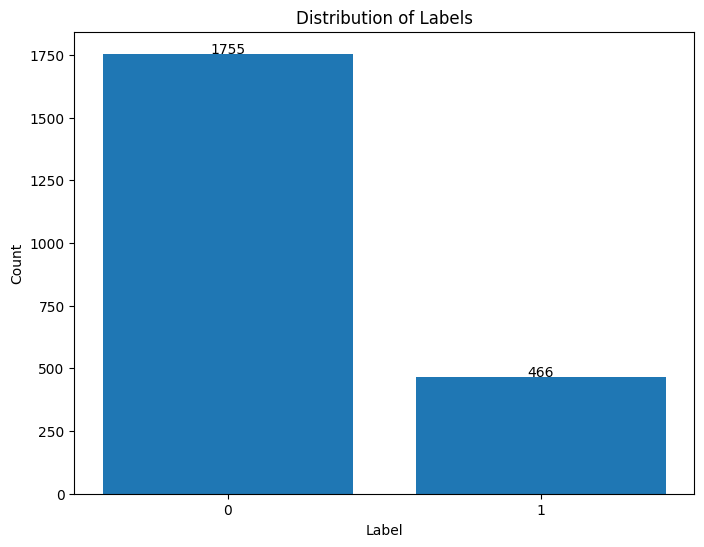

In [8]:
# 데이터 분포 확인

plot_distribution(preprocessed_articles)

In [9]:
# 훈련 데이터와 검증 데이터로 분리

train_articles, val_articles = train_test_split(
    preprocessed_articles,
    test_size=0.2,
    random_state=42
)

print(f"Number of training articles: {len(train_articles)}")
print(f"Number of validation articles: {len(val_articles)}")

Number of training articles: 1776
Number of validation articles: 445


Label 0: 79.28%
Label 1: 20.72%


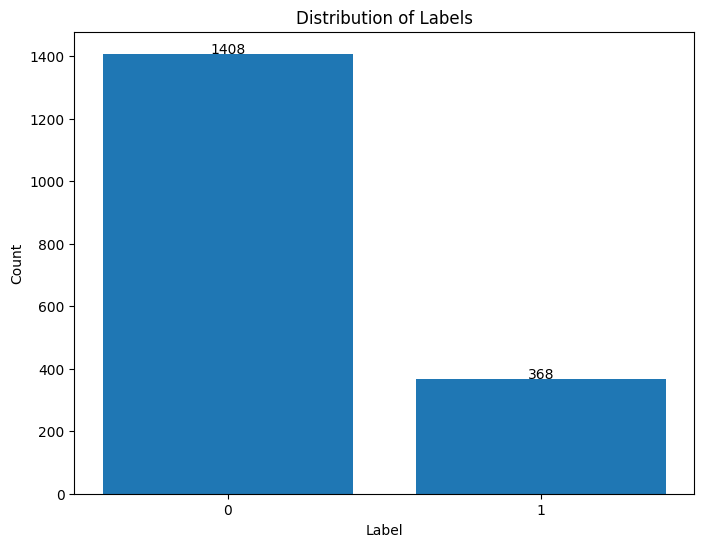

In [10]:
# 훈련 데이터의 데이터 분포 확인

plot_distribution(train_articles)

Label 0: 77.98%
Label 1: 22.02%


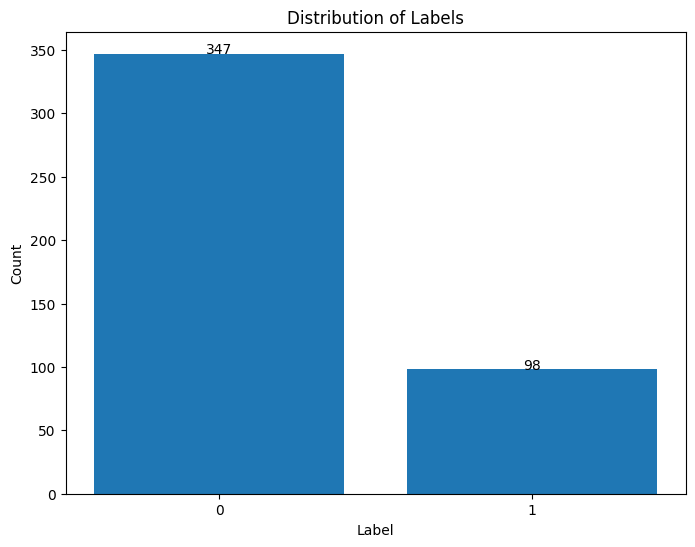

In [11]:
# 검증 데이터의 데이터 분포 확인

plot_distribution(val_articles)

In [12]:
# 토크나이저 설정

tokenizer = AutoTokenizer.from_pretrained('beomi/KcELECTRA-base-v2022')

print('Original:', preprocessed_articles[0]['content'])
print('Tokenized:', tokenizer.tokenize(preprocessed_articles[0]['content']))

Original: [CLS] 장학금 관련해서.. 성적장학금 + 한울장학금 가능한지 궁금합니다.. [SEP]
Tokenized: ['[CLS]', '장학금', '관련해서', '.', '.', '성적', '##장', '##학', '##금', '+', '한울', '##장', '##학', '##금', '가능한', '##지', '궁금합니다', '.', '.', '[SEP]']


In [13]:
# 텍스트 인코딩

train_contents = [article['content'] for article in train_articles]
train_labels = [article['label'] for article in train_articles]
val_contents = [article['content'] for article in val_articles]
val_labels = [article['label'] for article in val_articles]

train_encodings = tokenizer(
    train_contents,
    padding=True,
    truncation=True,
    return_tensors='pt',
    max_length=128
)
val_encodings = tokenizer(
    val_contents,
    padding=True,
    truncation=True,
    return_tensors='pt',
    max_length=128
)

train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(train_labels)
)
val_dataset = torch.utils.data.TensorDataset(
    torch.tensor(val_encodings['input_ids']),
    torch.tensor(val_encodings['attention_mask']),
    torch.tensor(val_labels)
)

/tmp/ipykernel_22890/2003359872.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(train_encodings['input_ids']),
/tmp/ipykernel_22890/2003359872.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(train_encodings['attention_mask']),
/tmp/ipykernel_22890/2003359872.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(val_encodings['input_ids']),
/tmp/ipykernel_22890/2003359872.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTenso

In [14]:
# 하이퍼파라미터 설정

BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 2e-5

In [15]:
# 학습 전 초기화

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

model = AutoModelForSequenceClassification.from_pretrained('beomi/KcELECTRA-base-v2022', num_labels=2)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_dataset) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_accs = []
train_losses = []
val_accs = []
val_losses = []

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3060 Ti


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# 학습 시작

for epoch in range(EPOCHS):
    model.train()

    train_loss = 0.0
    train_predictions = []
    train_labels_epoch = []

    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1} - Training'):
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

        train_predictions.extend(predictions.tolist())
        train_labels_epoch.extend(labels.tolist())

    train_acc = accuracy_score(train_labels_epoch, train_predictions)
    train_accs.append(train_acc)
    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)

    model.eval()

    val_loss = 0.0
    val_predictions = []

    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc=f'Epoch {epoch + 1} - Validation'):
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)

            val_predictions.extend(predictions.tolist())

    val_acc = accuracy_score(val_labels, val_predictions)
    val_accs.append(val_acc)
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)

    print(f'Epoch {epoch + 1}: Train Acc = {train_acc:.4f}, Train Loss = {train_loss:.4f}, Val Acc = {val_acc:.4f}, Val Loss = {val_loss:.4f}')

print('Training finished.')

Epoch 1 - Validation: 100%|██████████| 14/14 [00:01<00:00, 10.05it/s]


Epoch 1: Train Acc = 0.7900, Train Loss = 0.4855, Val Acc = 0.7888, Val Loss = 0.3633


Epoch 2 - Validation: 100%|██████████| 14/14 [00:01<00:00,  9.90it/s]


Epoch 2: Train Acc = 0.8834, Train Loss = 0.2725, Val Acc = 0.9326, Val Loss = 0.1776


Epoch 3 - Validation: 100%|██████████| 14/14 [00:01<00:00,  9.97it/s]


Epoch 3: Train Acc = 0.9499, Train Loss = 0.1375, Val Acc = 0.9483, Val Loss = 0.1745


Epoch 4 - Validation: 100%|██████████| 14/14 [00:01<00:00,  9.81it/s]


Epoch 4: Train Acc = 0.9752, Train Loss = 0.0837, Val Acc = 0.9393, Val Loss = 0.1665


Epoch 5 - Validation: 100%|██████████| 14/14 [00:01<00:00,  9.94it/s]

Epoch 5: Train Acc = 0.9831, Train Loss = 0.0576, Val Acc = 0.9551, Val Loss = 0.1873
Training finished.


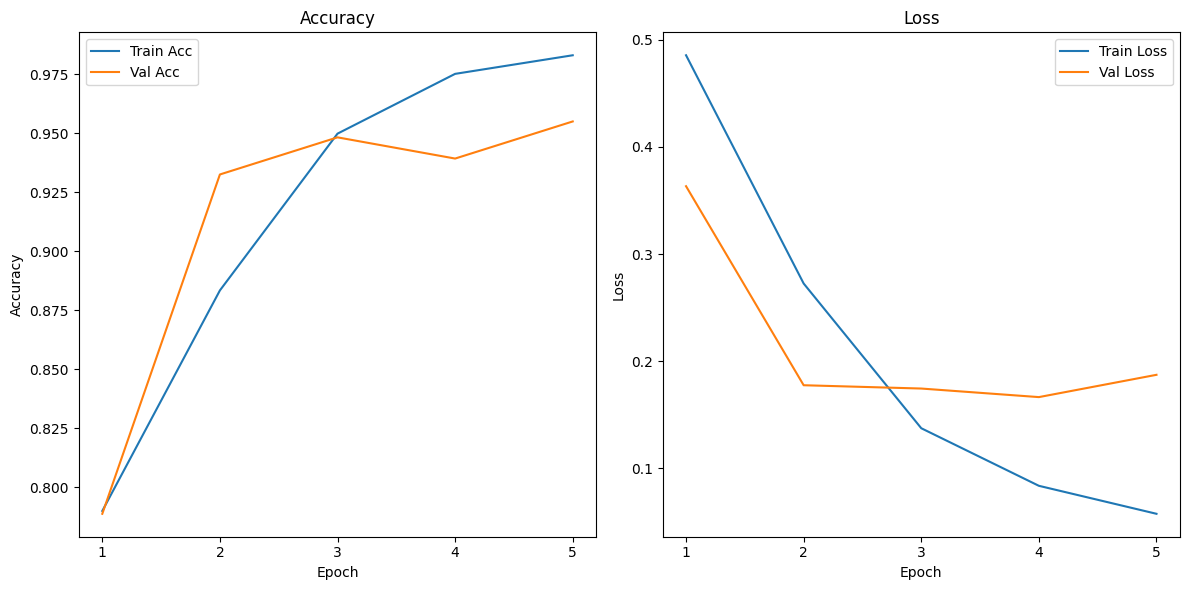

In [17]:
# 학습 결과 시각화

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.xticks(range(len(train_accs)), range(1, len(train_accs) + 1))
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.xticks(range(len(train_accs)), range(1, len(train_accs) + 1))
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.tight_layout()
plt.show()

In [18]:
# 평가

predictions = [
    '이번 학기 선형대수학 수업 너무 어려워요. 교수님 강의 스타일이 적응이 안 됩니다.',
    '자바 프로그래밍 과제 제출 기한이 언제까지인가요?',
    '데이터베이스 설계 프로젝트 팀원 구합니다. 같이 하실 분 연락 주세요.',
    '기계학습 수업에서 배우는 알고리즘들이 흥미롭네요. 실제 활용 사례도 알고 싶어요.',
    '오퍼레이션스 리서치 수업 듣는 사람 있나요? 같이 공부해요.',
    '축제 때 학교에서 벚꽃 구경하는 것도 좋더라.',
    '맛있는 점심 식사 했어요. 오늘 메뉴가 좋았어요.',
    'intramural soccer 동아리 활동이 재미있어요. 다음 경기가 기대됩니다.',
    '도서관에서 공부하다가 커피 마시러 갔어요.',
    '날씨가 좋아서 친구들이랑 한강 공원에서 운동했어요.',
    '장학금 받았는데 성적장학금인거 증명할 수 있는 증명서? 뽑을 수 있나요?'
]

encodings = tokenizer(
    [f'[CLS] {text} [SEP]' for text in predictions],
    padding=True,
    truncation=True,
    return_tensors='pt',
    max_length=128
)
input_ids = encodings['input_ids'].to(device)
attention_mask = encodings['attention_mask'].to(device)

with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    predicted_labels = torch.argmax(logits, dim=1).tolist()

for text, label, probs in zip(predictions, predicted_labels, probabilities.tolist()):
    sentiment = '수업/이과' if label == 1 else '그 외'
    print(f'텍스트: {text}')
    print(f'예측: {sentiment} {probs}')
    print()

텍스트: 이번 학기 선형대수학 수업 너무 어려워요. 교수님 강의 스타일이 적응이 안 됩니다.
예측: 수업/이과 [0.043345630168914795, 0.9566543102264404]

텍스트: 자바 프로그래밍 과제 제출 기한이 언제까지인가요?
예측: 수업/이과 [0.031010329723358154, 0.9689897298812866]

텍스트: 데이터베이스 설계 프로젝트 팀원 구합니다. 같이 하실 분 연락 주세요.
예측: 수업/이과 [0.028656331822276115, 0.9713436365127563]

텍스트: 기계학습 수업에서 배우는 알고리즘들이 흥미롭네요. 실제 활용 사례도 알고 싶어요.
예측: 수업/이과 [0.017558859661221504, 0.9824411273002625]

텍스트: 오퍼레이션스 리서치 수업 듣는 사람 있나요? 같이 공부해요.
예측: 수업/이과 [0.07882967591285706, 0.9211702942848206]

텍스트: 축제 때 학교에서 벚꽃 구경하는 것도 좋더라.
예측: 그 외 [0.9984140396118164, 0.0015859773848205805]

텍스트: 맛있는 점심 식사 했어요. 오늘 메뉴가 좋았어요.
예측: 그 외 [0.9978479146957397, 0.0021520659793168306]

텍스트: intramural soccer 동아리 활동이 재미있어요. 다음 경기가 기대됩니다.
예측: 그 외 [0.7373365759849548, 0.26266345381736755]

텍스트: 도서관에서 공부하다가 커피 마시러 갔어요.
예측: 그 외 [0.9982118606567383, 0.001788139226846397]

텍스트: 날씨가 좋아서 친구들이랑 한강 공원에서 운동했어요.
예측: 그 외 [0.9979890584945679, 0.002010989934206009]

텍스트: 장학금 받았는데 성적장학금인거 증명할 수 있는 증명서? 뽑을 수 있나요?
예측: 그 외 [0.99801981449127

In [19]:
# 모델 저장

tokenizer.save_pretrained('model')
model.save_pretrained('model')